In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob

In [2]:
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
img_path=glob.glob("d:/datasets/2_class/*/*.jpg")

In [4]:
img_path[:5],img_path[-5:]

(['d:/datasets/2_class\\airplane\\airplane_001.jpg',
  'd:/datasets/2_class\\airplane\\airplane_002.jpg',
  'd:/datasets/2_class\\airplane\\airplane_003.jpg',
  'd:/datasets/2_class\\airplane\\airplane_004.jpg',
  'd:/datasets/2_class\\airplane\\airplane_005.jpg'],
 ['d:/datasets/2_class\\lake\\lake_696.jpg',
  'd:/datasets/2_class\\lake\\lake_697.jpg',
  'd:/datasets/2_class\\lake\\lake_698.jpg',
  'd:/datasets/2_class\\lake\\lake_699.jpg',
  'd:/datasets/2_class\\lake\\lake_700.jpg'])

In [5]:
import random
random.shuffle (img_path )

In [6]:
img_path[:5],img_path[-5:]

(['d:/datasets/2_class\\airplane\\airplane_569.jpg',
  'd:/datasets/2_class\\airplane\\airplane_387.jpg',
  'd:/datasets/2_class\\lake\\lake_458.jpg',
  'd:/datasets/2_class\\airplane\\airplane_663.jpg',
  'd:/datasets/2_class\\airplane\\airplane_057.jpg'],
 ['d:/datasets/2_class\\lake\\lake_178.jpg',
  'd:/datasets/2_class\\lake\\lake_651.jpg',
  'd:/datasets/2_class\\lake\\lake_323.jpg',
  'd:/datasets/2_class\\lake\\lake_173.jpg',
  'd:/datasets/2_class\\lake\\lake_201.jpg'])

In [7]:
all_image_labels = [ int(p.split("\\")[1]=="lake") for p in img_path]

In [8]:
all_image_labels[-5:]

[1, 1, 1, 1, 1]

In [9]:
#定义函数读取、解码图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32)
    image = image/255.0  # normalize to [0,1] range
    return image

1183 airplane


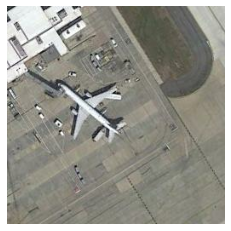

In [10]:
#随机选取图片显示，并输出标签
import matplotlib.pyplot as plt
rr=random.randint(0,len(img_path))
img_path_ = img_path[rr]
plt.imshow(load_and_preprocess_image(img_path_))
plt.axis("off")
print(rr,np.where(all_image_labels[rr]==1 ,"lake","airplane") )

In [11]:
train_val_count=int(len(img_path)*.85)  #取85%作为训练集与验证集数据
#含图片的路径的list转化为dataset，下同。方便后面用map函数将图片数据读入
train_val_img_path = tf.data.Dataset.from_tensor_slices(img_path[:train_val_count])    #转训练集与验证集
test_img_path=tf.data.Dataset.from_tensor_slices(img_path[train_val_count:])     #余下为测试集，转测试集

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_val_image_ds = train_val_img_path.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)   
#map，用load_and_preprocess_image函数遍历path_ds中每一个路径
#读入图片数据保存在image_ds，训练集图片

In [13]:
test_image_ds = test_img_path.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE) 
#map，用load_and_preprocess_image函数遍历path_ds中每一个路径
#读入图片数据保存在image_ds，测试集图片

In [14]:
#将训练集的标签转为dataset，方便后面用zip将图片与标签合并。zip（x,y）,x,y为同类型变量
train_val_label = tf.data.Dataset.from_tensor_slices(all_image_labels[:train_val_count])
#测试集标签仅在打印分类报告时使用，保持为list
test_label=all_image_labels[train_val_count:]

In [15]:
#将训练集、验证集的图片与对应的标签打包，方便后面验证集、训练集划分以及模型训练
train_val_image_label_ds = tf.data.Dataset.zip((train_val_image_ds, train_val_label))  

In [16]:
#取（训练集与验证集）中20%为为验证集的样本数量。
val_count = int(train_val_count*0.2)   
#训练集与验证集的样本数量减去验证集的样本数量，余下为训练集的样本数量
train_count = train_val_count - val_count  

In [17]:
val_count,train_count

(238, 952)

In [18]:
val_image_label_ds = train_val_image_label_ds.take(val_count)  #从image_label_ds中提取验证集数据
train_image_label_ds = train_val_image_label_ds.skip(val_count)  #提取余下的为训练集数据

In [19]:
train_image_label_ds,val_image_label_ds,test_image_ds  #查看

(<SkipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>)

In [20]:
BATCH_SIZE = 32

In [21]:
train_data_r = train_image_label_ds.repeat()
train_data_r_b = train_data_r.batch(BATCH_SIZE)
train_data = train_data_r_b.prefetch(AUTOTUNE)
#train_data=train_image_label_ds.repeat().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [22]:
val_data = val_image_label_ds.batch(BATCH_SIZE)  
test_data = test_image_ds.batch(BATCH_SIZE)

In [23]:
train_data,val_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>)

建立模型

In [24]:
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,113
Trainable params: 2,049
Non-trainabl

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)

In [27]:
steps_per_epoch = train_count//BATCH_SIZE

In [28]:
steps_per_epoch

29

In [29]:
history = model.fit(train_data, epochs=70, steps_per_epoch=steps_per_epoch, validation_data=val_data)

Epoch 1/70
29/29 [==============================] - 4s 42ms/step - loss: 0.4405 - acc: 0.8233 - val_loss: 0.6491 - val_acc: 0.5294
Epoch 2/70
29/29 [==============================] - 1s 37ms/step - loss: 0.3512 - acc: 0.8341 - val_loss: 0.6353 - val_acc: 0.5378
Epoch 3/70
29/29 [==============================] - 1s 37ms/step - loss: 0.3033 - acc: 0.8631 - val_loss: 0.6062 - val_acc: 0.5672
Epoch 4/70
29/29 [==============================] - 1s 37ms/step - loss: 0.2579 - acc: 0.8955 - val_loss: 0.5679 - val_acc: 0.6975
Epoch 5/70
29/29 [==============================] - 1s 36ms/step - loss: 0.2166 - acc: 0.9310 - val_loss: 0.5240 - val_acc: 0.7899
Epoch 6/70
29/29 [==============================] - 1s 37ms/step - loss: 0.1832 - acc: 0.9418 - val_loss: 0.4939 - val_acc: 0.8025
Epoch 7/70
29/29 [==============================] - 1s 36ms/step - loss: 0.1645 - acc: 0.9483 - val_loss: 0.4644 - val_acc: 0.8067
Epoch 8/70
29/29 [==============================] - 1s 36ms/step - loss: 0.1437 - a

29/29 [==============================] - 1s 36ms/step - loss: 0.0472 - acc: 0.9892 - val_loss: 0.1353 - val_acc: 0.9580
Epoch 64/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0520 - acc: 0.9838 - val_loss: 0.0539 - val_acc: 0.9790
Epoch 65/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0463 - acc: 0.9881 - val_loss: 0.1355 - val_acc: 0.9580
Epoch 66/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0438 - acc: 0.9860 - val_loss: 0.1042 - val_acc: 0.9664
Epoch 67/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0477 - acc: 0.9881 - val_loss: 0.1248 - val_acc: 0.9622
Epoch 68/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0497 - acc: 0.9871 - val_loss: 0.0418 - val_acc: 0.9874
Epoch 69/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0430 - acc: 0.9892 - val_loss: 0.0649 - val_acc: 0.9790
Epoch 70/70
29/29 [==============================] - 1s 36ms/step - loss: 0.0433 - acc: 

In [30]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

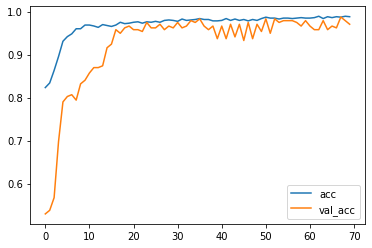

In [31]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

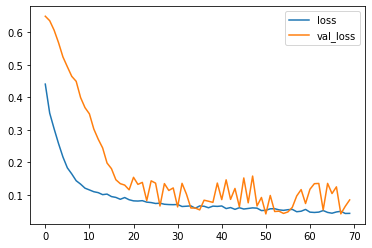

In [32]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

In [33]:
pred_prob=model.predict(test_data)  #预测1类的概率

In [34]:
pred_label=[int(i>0.5) for i in pred_prob]  #转化为类别标签

In [35]:
from  sklearn.metrics import classification_report  

In [36]:
print(classification_report(test_label,pred_label))  #打印分类报告

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       101
           1       0.97      0.98      0.98       109

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210

